In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()
from keras.preprocessing import image
from sklearn.model_selection import train_test_split

In [3]:
target = 'Attractive' #set this to Attractive or Babyface

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"

In [5]:
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000
pd.options.display.max_seq_items = 1000

In [6]:
# https://chicagofaces.org/default/
cfd_df_raw = pd.read_csv("CFD_Version_203/metadata.csv")

In [7]:
cfd_df_raw.head()

,Target,Race,Gender,Age,NumberofRaters,Female_prop,Male_prop,Asian_prop,Black_prop,Latino_prop,Multi_prop,Other_prop,White_prop,Afraid,Angry,Attractive,Babyface,Disgusted,Dominant,Feminine,Happy,Masculine,Prototypic,Sad,Suitability,Surprised,Threatening,Trustworthy,Unusual,Luminance_median,Nose_Width,Nose_Length,Lip_Thickness,Face_Length,R_Eye_H,L_Eye_H,Avg_Eye_Height,R_Eye_W,L_Eye_W,Avg_Eye_Width,Face_Width_Cheeks,Face_Width_Mouth,Forehead,Pupil_Top_R,Pupil_Top_L,Asymmetry_pupil_top,Pupil_Lip_R,Pupil_Lip_L,Asymmetry_pupil_lip,BottomLip_Chin,Midcheek_Chin_R,Midcheek_Chin_L,Cheeks_avg,Midbrow_Hairline_R,Midbrow_Hairline_L,Faceshape,Heartshapeness,Noseshape,LipFullness,EyeShape,EyeSize,UpperHeadLength,MidfaceLength,ChinLength,ForeheadHeight,CheekboneHeight,CheekboneProminence,FaceRoundness,fWHR
0,AF-200,A,F,32.571429,28,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.035714,1.571429,4.111111,2.857143,1.392857,1.928571,5.629630,2.928571,1.357143,3.659574,1.892857,.,2.821429,1.321429,3.925926,2.518519,174.0,230.5,250.5,135.5,1071.0,63.5,67.0,65.25,163.0,159.5,161.25,676.0,584.5,443.5,424.5,428.0,3.5,350.0,350.0,0.0,140.0,425.0,406.5,415.75,277.5,289.5,0.631186,1.156544,0.920160,0.126517,0.404651,0.060924,0.414099,0.326797,0.130719,0.264706,0.388189,91.5,0.545752,1.921146
1,AF-201,A,F,23.666667,27,1.000000,0.000000,0.962963,0.000000,0.000000,0.037037,0.000000,0.0,1.814815,3.111111,3.111111,2.481481,2.592593,2.111111,4.111111,1.555556,1.666667,3.893617,3.960000,.,1.370370,1.851852,3.538462,2.038462,172.0,233.5,235.0,129.0,1110.0,44.0,49.0,46.50,144.0,138.5,141.25,688.0,542.0,460.0,432.5,453.0,20.5,366.0,365.0,1.0,160.5,427.0,425.0,426.00,319.5,348.5,0.619820,1.269373,0.993617,0.116216,0.329204,0.041892,0.414414,0.329279,0.144595,0.300901,0.383784,146.0,0.488288,1.901129
2,AF-202,A,F,24.448276,29,0.827586,0.172414,0.310345,0.068966,0.137931,0.448276,0.034483,0.0,1.464286,1.862069,3.000000,2.344828,1.551724,2.862069,3.206897,2.379310,3.000000,1.808511,1.931034,.,1.551724,2.034483,3.379310,2.413793,153.5,277.5,268.0,141.5,1245.5,66.5,62.0,64.25,177.0,182.0,179.50,657.5,599.5,512.0,492.0,490.0,2.0,385.5,387.5,2.0,216.0,500.0,489.0,494.50,367.5,376.0,0.527900,1.096747,1.035448,0.113609,0.357939,0.051586,0.411080,0.310317,0.173424,0.298475,0.397029,58.0,0.481333,1.888249
3,AF-203,A,F,22.758621,29,1.000000,0.000000,0.758621,0.000000,0.068966,0.172414,0.000000,0.0,2.586207,1.655172,3.275862,3.862069,1.620690,1.750000,5.000000,2.571429,1.724138,2.531915,2.344828,.,1.931034,1.178571,3.793103,2.241379,175.5,233.5,240.0,129.5,1083.5,68.0,70.5,69.25,155.0,157.5,156.25,629.5,542.0,384.0,402.0,393.0,9.0,370.0,375.0,5.0,184.0,462.5,450.0,456.25,298.0,292.0,0.580988,1.161439,0.972917,0.119520,0.443200,0.063913,0.354407,0.343793,0.169820,0.272266,0.421089,87.5,0.500231,1.863719
4,AF-204,A,F,30.137931,29,1.000000,0.000000,0.827586,0.000000,0.068966,0.103448,0.000000,0.0,2.551724,1.586207,3.172414,2.068966,1.655172,1.758621,4.629630,1.275862,1.482759,2.574468,3.517241,.,1.137931,1.206897,3.310345,1.517241,168.5,252.5,257.5,100.0,1179.0,66.0,60.0,63.00,150.0,141.5,145.75,679.0,605.5,517.5,475.5,480.0,4.5,335.0,356.0,21.0,212.5,433.0,444.0,438.50,339.0,354.0,0.575912,1.121387,0.980583,0.084818,0.432247,0.053435,0.438931,0.293045,0.180237,0.293893,0.371925,73.5,0.513571,1.935783


In [8]:
cfd_df_raw.shape

(597, 69)

In [9]:
def getFileNames(target):
    files = []
    file_count = 0
    path = "CFD_Version_203/CFD_203_Images/%s/" % (target)
    for r, d, f in os.walk(path):
        for file in f: #BF-001 has several images
            if ('.jpg' in file) or ('.jpeg' in file) or '.png' in file:
                files.append(file)
    return files

In [10]:
cfd_df_raw["files"] = cfd_df_raw.Target.apply(getFileNames)

In [11]:
cfd_df_raw[['Target', 'files']].head()

,Target,files
0,AF-200,[CFD-AF-200-228-N.jpg]
1,AF-201,[CFD-AF-201-060-N.jpg]
2,AF-202,[CFD-AF-202-122-N.jpg]
3,AF-203,[CFD-AF-203-077-N.jpg]
4,AF-204,[CFD-AF-204-067-N.jpg]


In [12]:
cfd_instances = []
for index, instance in cfd_df_raw.iterrows():
    folder = instance.Target
    score = instance[target]
    for file in instance.files:
        tmp_instance = []
        #tmp_instance.append((target, file, score))
        tmp_instance.append(folder)
        tmp_instance.append(file)
        tmp_instance.append(score)
        cfd_instances.append(tmp_instance)

In [13]:
df = pd.DataFrame(cfd_instances, columns = ["folder", "file", "score"])

In [14]:
df[['file', 'score']].head()

,file,score
0,CFD-AF-200-228-N.jpg,4.111111
1,CFD-AF-201-060-N.jpg,3.111111
2,CFD-AF-202-122-N.jpg,3.000000
3,CFD-AF-203-077-N.jpg,3.275862
4,CFD-AF-204-067-N.jpg,3.172414


In [15]:
df.shape

(1207, 3)

In [16]:
def findEmotion(file):
    #file = CFD-WM-040-023-HO.jpg
    file_name = file.split(".")[0] #[1] is jpg
    emotion = file_name.split("-")[4]
    return emotion

def findRace(file):
    #file = CFD-WM-040-023-HO.jpg
    file_name = file.split(".")[0] #[1] is jpg
    race = file_name.split("-")[1][0]
    return race

def findGender(file):
    #file = CFD-WM-040-023-HO.jpg
    file_name = file.split(".")[0] #[1] is jpg
    gender = file_name.split("-")[1][1]
    return gender

In [17]:
df['emotion'] = df.file.apply(findEmotion)
df['race'] = df.file.apply(findRace)
df['gender'] = df.file.apply(findGender)

In [18]:
#include neutral, happen open mouth and happy close mouth
df = df[(df.emotion == 'N') | (df.emotion == 'HO') | (df.emotion == 'HC')]

In [19]:
#df[df.folder == 'WM-040']

In [20]:
df.shape

(904, 6)

In [21]:
df['file'] = "CFD_Version_203/CFD_203_Images/"+df["folder"]+"/"+df['file']

In [22]:
df.head()

,folder,file,score,emotion,race,gender
0,AF-200,CFD_Version_203/CFD_203_Images/AF-200/CFD-AF-2...,4.111111,N,A,F
1,AF-201,CFD_Version_203/CFD_203_Images/AF-201/CFD-AF-2...,3.111111,N,A,F
2,AF-202,CFD_Version_203/CFD_203_Images/AF-202/CFD-AF-2...,3.000000,N,A,F
3,AF-203,CFD_Version_203/CFD_203_Images/AF-203/CFD-AF-2...,3.275862,N,A,F
4,AF-204,CFD_Version_203/CFD_203_Images/AF-204/CFD-AF-2...,3.172414,N,A,F


In [23]:
def retrievePixels(path):
    img = image.load_img(path, grayscale=False, target_size=(224, 224))
    x = image.img_to_array(img).reshape(1, -1)[0]
    return x

In [24]:
df['pixels'] = df['file'].progress_apply(retrievePixels)

100%|██████████| 904/904 [00:55<00:00, 17.55it/s]


In [25]:
df.head()

,folder,file,score,emotion,race,gender,pixels
0,AF-200,CFD_Version_203/CFD_203_Images/AF-200/CFD-AF-2...,4.111111,N,A,F,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
1,AF-201,CFD_Version_203/CFD_203_Images/AF-201/CFD-AF-2...,3.111111,N,A,F,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
2,AF-202,CFD_Version_203/CFD_203_Images/AF-202/CFD-AF-2...,3.000000,N,A,F,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
3,AF-203,CFD_Version_203/CFD_203_Images/AF-203/CFD-AF-2...,3.275862,N,A,F,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
4,AF-204,CFD_Version_203/CFD_203_Images/AF-204/CFD-AF-2...,3.172414,N,A,F,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."


# Analyze data set

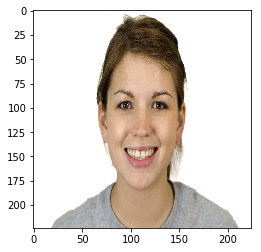

CFD_Version_203/CFD_203_Images/WF-022/CFD-WF-022-019-HO.jpg
Attractiveness score:  5.0869565219999995
-------------------


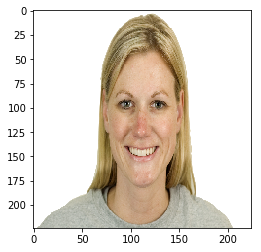

CFD_Version_203/CFD_203_Images/WF-003/CFD-WF-003-004-HO.jpg
Attractiveness score:  4.89010989
-------------------


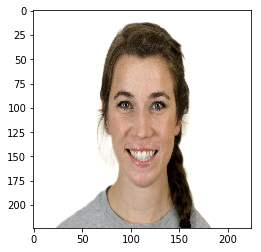

CFD_Version_203/CFD_203_Images/WF-024/CFD-WF-024-006-HO.jpg
Attractiveness score:  4.755319149
-------------------


In [28]:
for index, instance in df[(df.race == 'W') #A: Asian, B: Black, L: Latino, W: White]
                          & (df.gender == 'F') # F: Female / M: Male
                          & (df.emotion == 'HO') #HO: Happy Open Mouth, HC: Happy Closed Mouth, N: Neutral
                         ].sort_values(by=['score'], ascending = False).head(3).iterrows():
#for index, instance in df.sort_values(by=['score'], ascending = False).head(3).iterrows():
    img = instance.pixels
    img = img.reshape(224, 224, 3)
    img = img / 255
    
    plt.imshow(img)
    plt.show()
    print(instance.file)
    print("Attractiveness score: ",instance.score)
    
    print("-------------------")

# Pre-process features and target

In [29]:
features = []
pixels = df['pixels'].values
for i in range(0, pixels.shape[0]):
    features.append(pixels[i])

In [30]:
features = np.array(features)
features = features.reshape(features.shape[0], 224, 224, 3)

In [31]:
features = features / 255

In [32]:
features.shape

(904, 224, 224, 3)

# Train test split

In [33]:
#we have a few instances. that's why, do not use test and val sets differently
train_x, val_x, train_y, val_y = train_test_split(features, df.score.values, test_size=0.2, random_state=17)
#test_x, val_x, test_y, val_y = train_test_split(val_x, val_y, test_size=0.50, random_state=17)

In [34]:
print("train set: ", train_x.shape[0])
print("validation set: ", val_x.shape[0])
#print("test set: ", test_x.shape[0])

train set:  723
validation set:  181


# Modelling

In [35]:
import keras
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential

# Base VGG-Face Model

In [36]:
#VGG-Face model
base_model = Sequential()
base_model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
base_model.add(Convolution2D(64, (3, 3), activation='relu'))
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(64, (3, 3), activation='relu'))
base_model.add(MaxPooling2D((2,2), strides=(2,2)))
 
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(128, (3, 3), activation='relu'))
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(128, (3, 3), activation='relu'))
base_model.add(MaxPooling2D((2,2), strides=(2,2)))
 
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(256, (3, 3), activation='relu'))
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(256, (3, 3), activation='relu'))
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(256, (3, 3), activation='relu'))
base_model.add(MaxPooling2D((2,2), strides=(2,2)))
 
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(512, (3, 3), activation='relu'))
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(512, (3, 3), activation='relu'))
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(512, (3, 3), activation='relu'))
base_model.add(MaxPooling2D((2,2), strides=(2,2)))
 
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(512, (3, 3), activation='relu'))
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(512, (3, 3), activation='relu'))
base_model.add(ZeroPadding2D((1,1)))
base_model.add(Convolution2D(512, (3, 3), activation='relu'))
base_model.add(MaxPooling2D((2,2), strides=(2,2)))
 
base_model.add(Convolution2D(4096, (7, 7), activation='relu'))
base_model.add(Dropout(0.5))
base_model.add(Convolution2D(4096, (1, 1), activation='relu'))
base_model.add(Dropout(0.5))
base_model.add(Convolution2D(2622, (1, 1)))
base_model.add(Flatten())
base_model.add(Activation('softmax'))

In [37]:
#pre-trained weights of vgg-face model. 
#you can find it here: https://drive.google.com/file/d/1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo/view?usp=sharing
#related blog post: https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/
base_model.load_weights('vgg_face_weights.h5')

# Transfer Learning

In [38]:
num_of_classes = 1 #this is a regression problem

In [39]:
#freeze all layers of VGG-Face except last 7 one
for layer in base_model.layers[:-7]:
    layer.trainable = False

base_model_output = Sequential()
base_model_output = Flatten()(base_model.layers[-4].output)
base_model_output = Dense(num_of_classes)(base_model_output)

attractiveness_model = Model(inputs=base_model.input, outputs=base_model_output)

# Training

In [40]:
#sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9)
#attractiveness_model.compile(loss='mean_squared_error', optimizer=sgd)

attractiveness_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam())

In [41]:
checkpointer = ModelCheckpoint(
    filepath='%s.hdf5' % (target)
    , monitor = "val_loss"
    , verbose=1
    , save_best_only=True
    , mode = 'auto'
)

earlyStop = EarlyStopping(monitor='val_loss', patience=50)

In [ ]:
score = attractiveness_model.fit(
    train_x, train_y
    , epochs=5000
    , validation_data=(val_x, val_y)
    , callbacks=[checkpointer, earlyStop]
)


In [43]:
best_iteration = np.argmin(score.history['val_loss'])+1

val_scores = score.history['val_loss'][0:best_iteration]
train_scores = score.history['loss'][0:best_iteration]

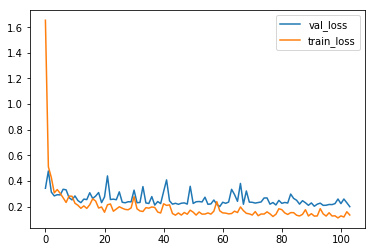

In [44]:
plt.plot(val_scores, label='val_loss')
plt.plot(train_scores, label='train_loss')
plt.legend(loc='upper right')
plt.show()

In [45]:
#restore the best weights
from keras.models import load_model
attractiveness_model = load_model("%s.hdf5" % (target))
attractiveness_model.save_weights('%s.h5' % (target))

# Performance

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

In [47]:
#actuals = test_y
#predictions = attractiveness_model.predict(test_x)
predictions = attractiveness_model.predict(val_x)
actuals = val_y

In [48]:
perf = pd.DataFrame(actuals, columns = ["actuals"])
perf["predictions"] = predictions

In [49]:
print("pearson correlation: ",perf[['actuals', 'predictions']].corr(method ='pearson').values[0,1])
print("mae: ", mean_absolute_error(actuals, predictions))
print("rmse: ", sqrt(mean_squared_error(actuals, predictions)))

pearson correlation:  0.7876312255072905
mae:  0.32754033469477695
rmse:  0.44623163710909775


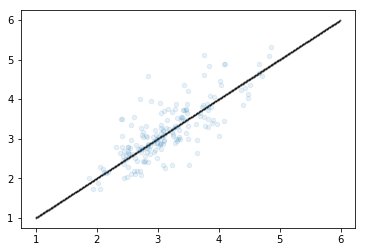

In [50]:
min_limit = df.score.min(); max_limit = df.score.max()
best_predictions = []

#for i in np.arange(1, 7, 0.01):
for i in np.arange(int(min_limit), int(max_limit)+1, 0.01):
    best_predictions.append(round(i, 2))

plt.scatter(best_predictions, best_predictions, s=1, color = 'black', alpha=0.5)
plt.scatter(predictions, actuals, s=20, alpha=0.1)

# IMDd Data Set

In [51]:
import scipy.io
mat = scipy.io.loadmat('../imdb_crop/imdb.mat')

In [52]:
columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score", "celeb_names", "celeb_id"]

In [53]:
instances = mat['imdb'][0][0][0].shape[1]

In [54]:
imdb_df = pd.DataFrame(index = range(0,instances), columns = columns)

In [55]:
imdb_df.shape

(460723, 10)

In [56]:
for i in mat:
    if i == "imdb":
        current_array = mat[i][0][0]
        for j in range(len(current_array)):
            #print(j,". ",columns[j],": ",current_array[j][0])
            imdb_df[columns[j]] = pd.DataFrame(current_array[j][0])

In [57]:
#imdb_df = imdb_df[imdb_df['gender'] == 0] #just ladies
#imdb_df = imdb_df[imdb_df['gender'] == 1] #just men

In [58]:
#remove pictures does not include face
imdb_df = imdb_df[imdb_df['face_score'] != -np.inf]

#some pictures include more than one face, remove them
imdb_df = imdb_df[imdb_df['second_face_score'].isna()]

#check threshold
imdb_df = imdb_df[imdb_df['face_score'] >= 3]

In [59]:
imdb_df.shape

(95234, 10)

In [60]:
def extractNames(name):
    return name[0]

imdb_df['celebrity_name'] = imdb_df['name'].apply(extractNames)

In [61]:
from datetime import datetime, timedelta
def datenum_to_datetime(datenum):
    try:
        days = datenum % 1
        hours = days % 1 * 24
        minutes = hours % 1 * 60
        seconds = minutes % 1 * 60
        exact_date = datetime.fromordinal(int(datenum)) \
        + timedelta(days=int(days)) + timedelta(hours=int(hours)) \
        + timedelta(minutes=int(minutes)) + timedelta(seconds=round(seconds)) \
        - timedelta(days=366)
        year = exact_date.year
    except:
        year = -1
    return year

In [62]:
imdb_df['date_of_birth'] = imdb_df['dob'].apply(datenum_to_datetime)
imdb_df = imdb_df[imdb_df.date_of_birth > 0]
imdb_df['age'] = imdb_df.photo_taken - imdb_df.date_of_birth      
imdb_df = imdb_df[(imdb_df.age >= 18) & (imdb_df.age <= 50)]

In [63]:
imdb_df.head()

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,celeb_names,celeb_id,celebrity_name,date_of_birth,age
12,702986,1974,[02/nm0000002_rm221957120_1924-9-16_1974.jpg],0.0,[Lauren Bacall],"[[3173.144692593433, 401.0408365741791, 4059.1...",4.096431,NaN,[A.J. Trauth],11516,Lauren Bacall,1924,50
14,702986,1974,[02/nm0000002_rm238734336_1924-9-16_1974.jpg],0.0,[Lauren Bacall],"[[2135.2177839424635, 765.8537799794512, 3499....",4.865421,NaN,[AJ Bowen],11516,Lauren Bacall,1924,50
47,706650,1963,[03/nm0000003_rm1883436032_1934-9-28_1963.jpg],0.0,[Brigitte Bardot],"[[4.054, 652.694, 1167.552, 1816.192]]",3.056358,NaN,[Aaron Seltzer],2585,Brigitte Bardot,1934,29
50,706650,1963,[03/nm0000003_rm2034430976_1934-9-28_1963.jpg],0.0,[Brigitte Bardot],"[[1045.2505006892818, 350.00950022976065, 1564...",3.776049,NaN,[Aaron Stanford],2585,Brigitte Bardot,1934,29
64,706650,1965,[03/nm0000003_rm3428825856_1934-9-28_1965.jpg],0.0,[Brigitte Bardot],"[[246.62203248711663, 246.62203248711663, 561....",4.260661,NaN,[Abdallah El Akal],2585,Brigitte Bardot,1934,31


In [65]:
def getOriginalSize(image_path):
    img = image.load_img("../imdb_crop/%s" % image_path[0], grayscale=False)
    x = image.img_to_array(img).reshape(1, -1)[0]
    return x.shape[0]
    
def getImagePixels(image_path):
    img = image.load_img("../imdb_crop/%s" % image_path[0], grayscale=False, target_size=(224, 224, 3))
    x = image.img_to_array(img).reshape(1, -1)[0]
    return x

In [66]:
imdb_df['pixels'] = imdb_df['full_path'].progress_apply(getImagePixels)

100%|██████████| 79091/79091 [05:25<00:00, 243.04it/s] 


In [67]:
imdb_df['num_of_pixels'] = imdb_df['full_path'].progress_apply(getOriginalSize)

100%|██████████| 79091/79091 [04:45<00:00, 276.74it/s]


In [68]:
imdb_features = []
pixels = imdb_df['pixels'].values
for i in range(0, pixels.shape[0]):
    imdb_features.append(pixels[i])

In [69]:
imdb_features = np.array(imdb_features)
imdb_features = imdb_features.reshape(imdb_features.shape[0], 224, 224, 3)

In [70]:
imdb_features = imdb_features / 255

In [71]:
imdb_df['attractiveness_score'] = attractiveness_model.predict(imdb_features)

In [72]:
imdb_df_raw = imdb_df.copy()

In [96]:
#restore
#imdb_df = imdb_df_raw.copy()

In [74]:
dropDuplicates = False

if dropDuplicates:
    print(imdb_df.shape)
    imdb_df_best = imdb_df.groupby("celebrity_name", as_index=False)["attractiveness_score"].max()
    imdb_df = imdb_df.merge(imdb_df_best, on =["celebrity_name", "attractiveness_score"], how="inner")
    print(imdb_df.shape)

In [99]:
imdb_df = imdb_df.sort_values(by=['attractiveness_score'], ascending=False)
imdb_df = imdb_df.reset_index(drop=True)

Rebecca Hall  ( 17/nm0356017_rm1243584256_1982-5-3_2008.jpg ) -  26  years old
Attractiveness score:  83.57


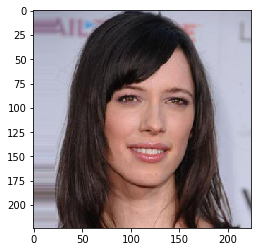

-----------------
Christina Aguilera  ( 94/nm0004694_rm2469435904_1980-12-18_2005.jpg ) -  25  years old
Attractiveness score:  78.49


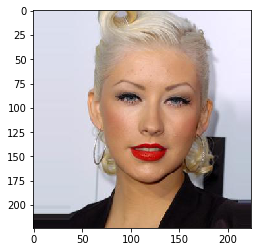

-----------------
Selita Ebanks  ( 45/nm2115545_rm2587423232_1983-2-15_2015.jpg ) -  32  years old
Attractiveness score:  77.29


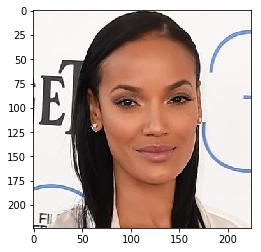

-----------------


In [119]:
tmp_df = imdb_df[imdb_df.gender == 0] #0: woman, 1: man
tmp_df = tmp_df[tmp_df.num_of_pixels >= 100000]
tmp_df = tmp_df[(tmp_df.age >= 21) & (tmp_df.age <= 35)]
tmp_df = tmp_df[tmp_df.face_score >= 4]
tmp_df = tmp_df.reset_index(drop=True)

for index, instance in tmp_df[(tmp_df.index >= 0) & (tmp_df.index < 3)].iterrows():
    
    print(instance["name"][0]," (",instance.full_path[0],") - ",instance.age," years old")
    
    attractiveness_score = instance.attractiveness_score
    
    attractiveness_score = 100 * (attractiveness_score - min_limit) / (max_limit - min_limit)
    attractiveness_score = round(attractiveness_score, 2)

    print("Attractiveness score: ", attractiveness_score)
    
    img = instance["pixels"]
    img = img.reshape(224, 224, 3)
    img = img / 255
    
    plt.imshow(img)
    plt.show()
    
    print("-----------------")
    #break

In [ ]:
print("hello, world!")